After speaking to a number of academics involved with Monte Carlo simulations, I realised many of them resort to creating bash scripts to 
run a number of python instances of simulation before writing another script to piece the data back together. It turns out this is incredibly simple 
to do in IPython, and in particular in an IPython Notebook. We take a look at how to run computations in parallel as well as giving a use-case in the creation of Julia fractals.

Most modern CPUs have 2 or more cores, allowing for everyone to take full advantage of parallel computing. The IPython implementation here is probably most useful for when
you have some computationally intensive program which is not called on a regular basis. Writing a full parallel implementation can be time consuming (depending on the problem and the 
experience of the programmer), however as we'll see, writing an implementation in IPython can be quick and painless. Of course more tailored parallel implementations require more effort 
should use a more established MPI such as OpenMPI. Thankfully this can be done within the IPython framework.

To begin, we will set up the engines that we will use for our computation. 

## Basics

The client is handler for all of the engines (kernels) on a cluster.

In [2]:
from IPython.parallel import Client
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Before we start, we first need to assign a number of engines in our cluster. This can be done through the IPython notebook interface or through the command line. The basic syntax is

```
$ ipcluster start -n 4
```

which starts a cluster of 4 engines to compute on. For more help use ``` $ ipcluster -h ```
or consult the [documentation](https://ipython.org/ipython-doc/dev/parallel/parallel_process.html) to set up engines with specific settings or parameters by creating a profile.

We begin by calling the Client() function.

In [3]:
client = Client()
client.block = True # Computations run synchronously.
print client.ids

[0, 1]


If there are no engines running, or they are incorrectly set up then this will throw an error.

The way we access the engines is through client *views*. There are two types of view:

#### Direct Views

Direct views allows the computation of a task on all of the engines simultaneously:

In [4]:
dview = client.direct_view()

In [5]:
def f(x):
    return x

dview.apply(f, "Hello World")

['Hello World', 'Hello World']

One can also select a subset of the engines directly using list slicing:

In [6]:
even_dview = client[::2]
even_dview.apply(f, "Hello World")

['Hello World']

#### Load Balanced Views

A load balanced view allows the computation of a task on any one engine. The engine is chosen by the scheduler using some black box logic.

In [7]:
bview = client.load_balanced_view()

bview.apply(f, "Hello World")

'Hello World'

#### How do we execute code?

There are many ways to execute code in a Direct view. As an example we will get each engine to return its process ID (PID).
If we were considering one engine only we would run:

In [8]:
import os
print os.getpid()

28100


As shown before, we can apply a function (with parameters if needed) to the view, which returns the result for each engine in a list.

In [9]:
dview.apply(os.getpid)

[28148, 28154]

Alternatively we can apply a function decorator to our function and call it as normal. A function decorator is a wrapper function, or a function which has one or more functions as a parameter.

In [10]:
@dview.remote(block=True)
def getpid():
    import os
    return os.getpid()

getpid()

[28148, 28154]

Another method uses the cell magic ``` %%px ``` or line magic ``` %px ```. This executes the line or cell on a direct view of the current client (specifically its current list of targets).


In [11]:
%%px 
import os
print os.getpid()

[stdout:0] 28148
[stdout:1] 28154


Finally, and most fundamentally, one can excute a string of code using the *execute* function.

In [12]:
res = dview.execute('print os.getpid()')
res.display_outputs()

[stdout:0] 28148
[stdout:1] 28154


#### Imports and Environments

Chances are if one is concerned with computation speed, you will be using numpy and scipy or any number of packages or custom scripts. As with executing code, there are multiple ways to manage imports:

In [13]:
dview.execute('import numpy')

<AsyncResult: finished>

In [14]:
%px import numpy

In [15]:
with dview.sync_imports():
    import numpy

importing numpy on engine(s)


The later method uses the context manager ``` sync_imports ``` which simultaneously sets the local and remote imports.

It is also possible for all remote engines to run a centralised script. This could be used for imports, defining application functions, or actual computation.

In [16]:
%%file script.py

def hello_world():
    print "Hello World"

hello_world()

Writing script.py


In [17]:
dview.run("script.py").display_outputs()

[stdout:0] Hello World
[stdout:1] Hello World


Since the computational engines are all running with IPython, then %magics are supported, as well as inline plotting, for example,

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib


[output:0]

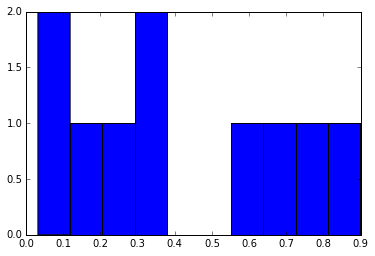

[output:1]

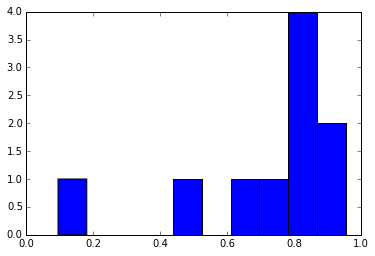

In [19]:
%%px 
%pylab inline
z = np.random.random(10)
hist(z);

#### Accessing and Setting Data

Accessing and setting data can be done in multiple ways (spotting a theme here?). All variables and objects on each engine can be accessed like a dictionary using the direct view. We are not limited to accessing purely what we have assigned, anything in the global namespace on the remote engine is fair game.

In [20]:
dview['a'] = 5
dview['b'] = 10
print dview['a']
print dview['os.getpid']

[5, 5]
[<built-in function getpid>, <built-in function getpid>]


Values can be set and retrieved using the more conventional *push* and *pull* methods respectively.

In [21]:
dview.push(dict(a=1, b=2))
dview.pull(('a','b'))

[[1, 2], [1, 2]]

Arrays can be distributed evenly over the engines using the *scatter* method.

In [22]:
a = np.arange(32)
dview.scatter('a', a)
%px print a

[stdout:0] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[stdout:1] [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]


This allows us to compute the result for each array before using the *gather* method to piece them back together.

In [23]:
%px a = a**2
dview.gather('a')

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625,
       676, 729, 784, 841, 900, 961])

#### Load Balanced Views

Direct views are simple to understand and are extremely useful when we know how to split our computation up efficiently. In some cases however there may be a list of computational tasks with undetermined computational runtime which is where a load balanced view becomes useful. The load balanced view was defined earlier as:

``` python
bview = client.load_balanced_view()
```

Below we have a function which will hopefully illustrate how the view behaves. The function sleeps for a random amount of time before returning the PID of the engine and a random number multiplied by an inputted factor.

In [24]:
def random_number(factor):
    import time
    import os
    import random
    r = random.random()
    time.sleep(5*r)
    return os.getpid(), factor*r

If we apply a function to the load balanced view we receive only one result as the function has been only been executed once.

In [25]:
bview.block=True
bview.apply(random_number,1)

(28148, 0.13589479515258984)

To pass in multiple inputs (effectively creating a queue of parameters), we can use the *map* function. By setting ```bview.block=False ``` we allow the results to stream in asynchronously.

In [26]:
bview.block = False
res = bview.map(random_number, range(10))

The map instantly returns an *AsyncResult* object which begins empty and collects the results as they are computed. To check whether the computation is complete we run

In [27]:
res.ready()

False

which in this case is ```False```. After waiting a sufficient amount of time, the complete result becomes available:

In [29]:
print res.ready()
print res.result

True
[(28154, 0.0), (28148, 0.353121228183755), (28148, 0.8912804195694612), (28148, 0.2574080792655825), (28154, 3.0649744188151655), (28148, 4.647279778078658), (28154, 5.984501696992297), (28148, 3.6116319893262663), (28148, 0.3236199407999898), (28148, 4.738358754671982)]


If we call result before the computation is complete then the system will wait until it is. Note that there is no particular ordering to the engine used - the scheduler is picking the next available engine to run the function. The load balanced view map is also iterable which allows for results to be returned as and when they become available.

In [30]:
for result in bview.map(random_number, range(10)):
    print result

(28154, 0.0)
(28148, 0.8757407390027869)
(28154, 0.5549081099622204)
(28148, 1.1504307801739788)
(28154, 3.808983692442408)
(28148, 4.229545895246912)
(28154, 5.3454061969056115)
(28148, 6.358402364906841)
(28154, 3.0457894904408818)
(28148, 3.7000890699309696)


## Applying Parallel Computing to Fractals (Julia sets)

Now for an interesting application. Since everyone has [estimated $\pi$](https://www.youtube.com/watch?v=VJTFfIqO4TU) a thousand times before we'll avoid that example. Instead we'll look at visualising [Julia sets](http://en.wikipedia.org/wiki/Julia_set), closely following this well written guide to [Numpy/SciPy Recipes for Image Processing](http://www.researchgate.net/publication/272679245_NumPy__SciPy_Recipes_for_Image_Processing_Creating_Fractal_Images).

#### Theory in Brief

We consider a rational function $f: \mathbb{C} \to \mathbb{C}$. In this example we'll consider the function $f(z) = z^2 + c$ where $c \in \mathbb{C}$. Written in Python this function is:

In [31]:
def f(z, c=-.065+.66j):
    return z**2 + c

Note that Python uses the letter ```j``` rather than ```i``` for the complex unit.

We can use this function as an iterative map on the complex plane, i.e we have $z_t = f(z_{t-1}) = \dots = f^t(z_0)$. There are two possibilities which can happen, either $|z_t|$ diverges as $t \to \infty$, or $|z_t|$ remains bounded.

Points where $f^t(z)$ diverge are called the *escape set* of $f$, and points which do not diverge are called the *prisoner set* of $f$. The Julia set of $f$ is then defined to be the boundary of the prisoner set, i.e,

$$J(f) = \partial  \left\{ z \in \mathbb{C} \left\vert  \frac{}{}\right . \lim_{t \to \infty} |f^t(z)|< \infty \right\} $$

The interesting fact about this dynamical system is that it behaves chaotically for almost all $c$, that is to say that two nearby points $z_0$ and $z_0 + \epsilon$ will likely yield very different trajectories in the large $t$ limit.

To begin with we define the section of the complex plane we want to explore (```zmin``` and ```zmax```) as well as our resolution (```m``` and ```n```). The resolution defines how many inital conditions we are going to sample, which in this case is $mn=1024^2$.

In [32]:
m=1024
n=1024
zmin = -1.3 - 1j * 1.3
zmax = 1.3 + 1j * 1.3

xs = np.linspace(zmin.real, zmax.real, n)
ys = np.linspace(zmin.imag, zmax.imag, m)
X, Y = np.meshgrid(xs, ys)
Z = X + 1j * Y

Using the ```meshgrid``` function we can easily create an array of complex numbers.

In [33]:
print Z[:2,:2]

[[-1.30000000-1.3j        -1.29745846-1.3j       ]
 [-1.30000000-1.29745846j -1.29745846-1.29745846j]]


#### Application

The Julia set itself is very difficult to be determined exactly and so we plot the escape set of the function instead.
For each initial condition we count the number of iterations until the map escapes a threshold radius, and plot this.

In [34]:
def julia(f, Z, tmax=256):
    J = np.ones(Z.shape) * tmax
    for t in xrange(tmax):
        mask = np.abs(Z) <= 2.
        Z[ mask] = f(Z[mask])
        J[-mask] -= 1
    return J

The above function carries out this function in a very succinct fashion. Firstly, we initialise an array with our maximum iteration number. We then check our complex plane array to see if any values have a modulus greater than 2. This creates a *boolean index array* which we can use to select only the elements in our array ```Z``` which satisfy the condition.

Iterating the process ```tmax``` times we then arrive at our array ```J``` which distinguishes between escape times for each initial conditions. We can also run the algorithm in the other direction for the same result. The use of the boolean arrays means that if an iteration of the function escapes the threshold radius we do not ever apply the map again to the function - saving valuable computational time!

Below we first create a copy of ```Z``` since our julia function edits the array in-place and we will want to use the original again later.

In [78]:
ZZ = np.copy(Z)
J = julia(f, ZZ)

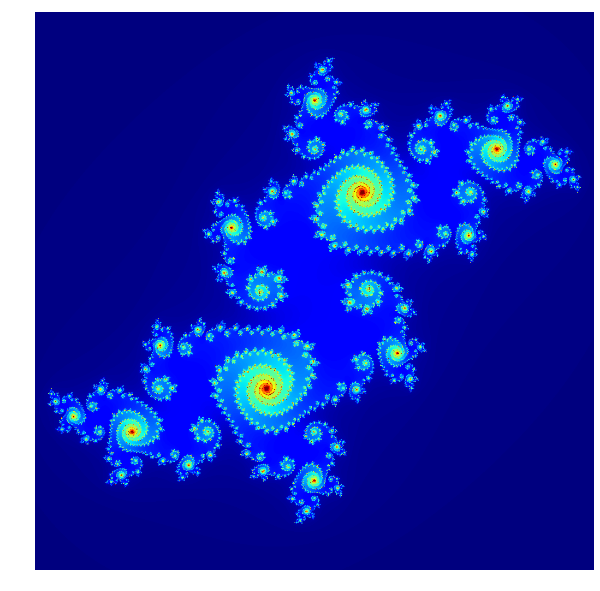

In [79]:
figure(figsize=[10,10])
imshow(J)
axis('off');

In parallel we first feed the functions to each engine.

In [80]:
%%px

import numpy as np

def f(z, c=-.065+.66j):
    return z**2 + c

def julia_parallel(f,Z,tmax=256):
    J = np.ones(Z.shape) * tmax
    for t in xrange(tmax):
        mask = np.abs(Z) <= 2.
        Z[mask] = f(Z[mask])
        J[-mask] -= 1
    return J

We can then scatter/distribute the array amoungst the different engines. Each engine runs the same number of loops on the same sized array so in theory the load should be evenly distributed. In reality the size of the masks may vary so one would expect some deviation in the workloads. 

In [81]:
dview.scatter('Z', Z)
%px ZZ = np.copy(Z)
%px J = julia_parallel(f,ZZ)
PJ = dview.gather('J')

Piecing together all the parts we arrive at the same fractal as before.

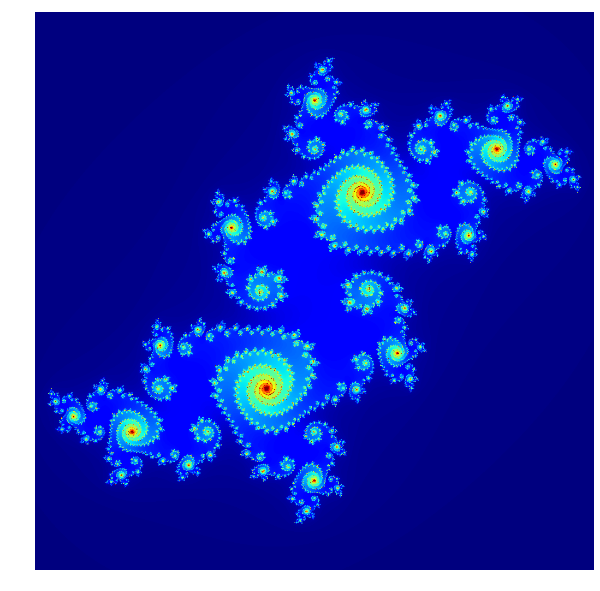

In [82]:
figure(figsize=[10,10])
imshow(PJ)
axis('off');

So did we speed it up?

In [83]:
Z = X + 1j * Y

In [84]:
%%time

J = julia(f, Z)

CPU times: user 6.88 s, sys: 6 ms, total: 6.88 s
Wall time: 6.87 s


In [85]:
Z = X + 1j * Y

In [86]:
%%time 

dview.scatter('Z', Z)
%px ZZ = np.copy(Z)
%px J = julia_parallel(f,ZZ)
PJ = dview.gather('J')

CPU times: user 287 ms, sys: 0 ns, total: 287 ms
Wall time: 1.97 s


So we see that the computational time has indeed been reduced by a factor of the number of engines we chose at the start (plus some overhead). For this small example the overhead is relatively large, however if we wanted to double or triple the resolution then this overhead would become insignificant.

Of course no speed test is complete without checking that the answers agree,

In [87]:
np.allclose(J,PJ)

True

which thankfully they do!

## One last thing...

My first introduction to parallel computing was a bit of a trial by fire, creating a single script to run on multiple cores, being careful with master/slave logic, and making sure the right result came out of the other end. By contrast, the IPython parallel tools seem intuitive and easy to use and it is quick and easy to get something workable. For areas such as finance or agent-based modelling which require the use of lots of Monte Carlo simulation this is a god-send for early exploration as well as churning out larger results.

For larger computations one would naturally move out of the notebook environment for a speed up. It is also possible to [use MPI with IPython](https://ipython.org/ipython-doc/dev/parallel/parallel_mpi.html) for applications which require a large number of engines or require a substantial number/volume of messages to passed between engines.


---
#### References

[Fractals](http://www.researchgate.net/publication/272679245_NumPy__SciPy_Recipes_for_Image_Processing_Creating_Fractal_Images) *Christian Bauckhage*

[Parallel IPython Notebook 1](http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/21_IPythonParallel) *Jake Vanderplas*

[Parallel IPython Notebook 2](http://nbviewer.ipython.org/github/ccwang002/2013-ML-TeamProject/blob/master/parallel_play.ipynb) *Liang Bo Wang*

[Using MPI with IPython](https://ipython.org/ipython-doc/dev/parallel/parallel_mpi.html) *Documentation*